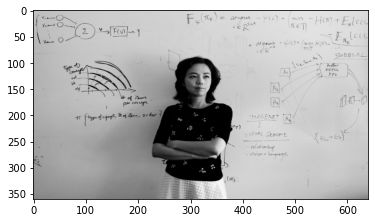

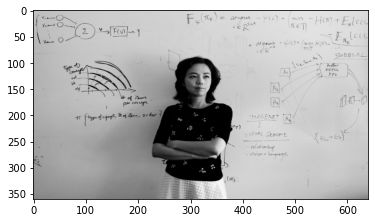

rectangles[[(291, 113) (343, 164)]]


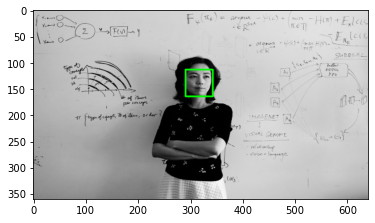

In [1]:
# 이미지 처리를 위한 opencv와 이미지 출력을 위한 matplotlib
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 준비한 이미지 읽기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 이 사진은 640x360(16:9)의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. 
# 그래서 여러분의 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것입니다. 
# 그래서, opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리를 해주게 됩니다.

# plt.imshow 이전에 RGB 이미지로 바꾸기 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


# 얼굴 검출
# dlib을 활용해 hog detector를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

#detector를 이용해서 얼굴의 bounding box를 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 랜드마크
face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다.
keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다. 

68


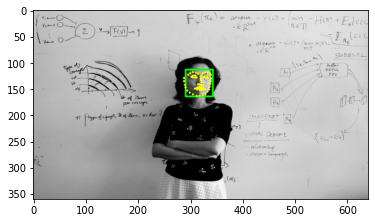

In [4]:
# 저장한 landmark 모델을 불러옵니다.
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# 랜드마크 영상 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [5]:
# 좌표확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('코 위의 눈썹 중앙 위치 (x,y) : (%d,%d)'%(x,y))
    print ('landmark의 크기 (w,h) : (%d,%d)'%(w,h))

(321, 137)
코 위의 눈썹 중앙 위치 (x,y) : (321,111)
landmark의 크기 (w,h) : (53,53)


(53, 53, 3)
스티커의 top-left가 될 (x,y) : (295,111)
(53, 53, 3)
(x,y) : (295,58)


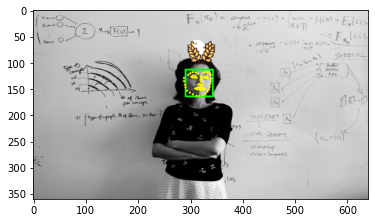

53
295
53


In [8]:
#스티커 읽어오기
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hero.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 리사이즈
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y  # top
print ('스티커의 top-left가 될 (x,y) : (%d,%d)'%(refined_x, refined_y))

# 사진 밖으로 나가는 건 crop하기
# img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

# 음수가 아닐 때
refined_y:refined_y+img_sticker.shape[0]
print (img_sticker.shape)

refined_y = y-h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# print(sticker_area[1])
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(img_sticker.shape[0])
print(refined_x)
print(img_sticker.shape[1])

In [ ]:
#스티커 읽어오기
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/hero.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 리사이즈
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 사진 밖으로 나가는 건 crop하기
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

sticker_area = img_show[refined_y:img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[0]]
img_show[refined_y:img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[0]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(img_sticker.shape[0])
print(refined_x)
print(img_sticker.shape[1])

img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# # 흑백사진으로 바꿔서 출력해 볼 것

# # 이미지 읽기
# img_gry = cv2.imread('img_rgb', cv2.IMREAD_GRAYSCALE)
# # 이미지 보기
# cv2.imshow('img_rgb', img_rgb)
# plt.show()